# Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import torch
import torchvision
from petastorm import TransformSpec
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from functools import partial 
from torch import nn
from sklearn import preprocessing
from torch.utils.data import DataLoader
from torchdata.datapipes.iter import FileLister
import datetime as dt
from petastorm.spark import SparkDatasetConverter, make_spark_converter
from torchvision import transforms
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data
import matplotlib.dates as mdates

/home/nuno/.local/lib/python3.10/site-packages/petastorm/spark/spark_dataset_converter.py:28: FutureWarning: pyarrow.LocalFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  from pyarrow import LocalFileSystem


In [2]:
spark = SparkSession \
    .builder \
    .appName("Data_Forecasting") \
    .config("spark.memory.offHeap.enabled","true") \
    .config("spark.driver.cores","4") \
    .config("spark.driver.maxResultSize","4g") \
    .config("spark.memory.offHeap.size","4g") \
    .config("spark.driver.memory", "4g")\
    .config("spark.executor.memory","4g")\
    .getOrCreate()

23/05/18 15:36:47 WARN Utils: Your hostname, nuno-g14 resolves to a loopback address: 127.0.1.1; using 192.168.1.185 instead (on interface wlp2s0)
23/05/18 15:36:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/18 15:36:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
print(dev)

cuda:0


# Auxiliary Functions

In [4]:
def create_dataset(dataset, lookback, future_step):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        if i+future_step < len(dataset) and i+lookback+future_step < len(dataset):
            feature = dataset[i:i+lookback]
            target = dataset[i+future_step:i+lookback+future_step]
            X.append(feature)
            y.append(target)
    
    return torch.tensor(X).to(device), torch.tensor(y).to(device)

In [5]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

# Data Reading & Preparation

In [6]:
sparkDF = spark.read.parquet("../MSc_Model_Datasets/Data_SEF_Clean.parquet")

In [7]:
# sparkDF.show(20)

In [9]:
date_list = sparkDF.select("Data_Checkin").distinct().collect()
date_frame = spark.createDataFrame(data=date_list, schema=["Date"])
count_frame = sparkDF.groupBy("Data_Checkin").agg(count("Data_Checkin").alias("Portugal_Count"))
dataset = date_frame.join(count_frame, count_frame.Data_Checkin == date_frame.Date).select(date_frame.Date,count_frame.Portugal_Count)
dataset = dataset.sort(col("Date").asc())
data_SEF = dataset.toPandas()

In [10]:
display(data_SEF)

,Date,Portugal_Count
0,1388534400,7453
1,1388620800,9936
2,1388707200,7212
3,1388793600,7323
4,1388880000,5305
...,...,...
1684,1534028400,36561
1685,1534114800,32798
1686,1534201200,19958
1687,1534287600,11047


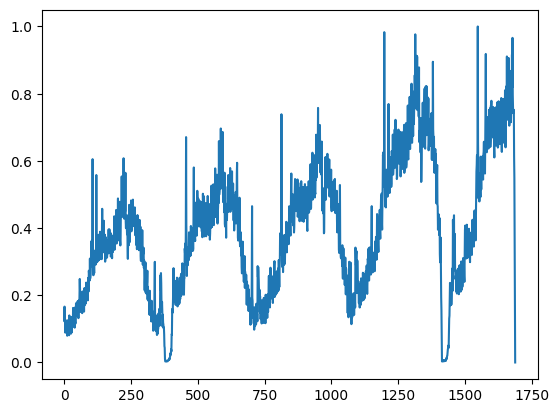

In [11]:
date_list = data_SEF[["Date"]].values
timeseries = data_SEF[["Portugal_Count"]].values.astype('float32')
min_max_scaler = preprocessing.MinMaxScaler()
timeseries = min_max_scaler.fit_transform(timeseries)

plt.plot(timeseries)
plt.show()

# Forecasting Model

## Forecasting Model - Setup

In [440]:
# HYPERPARAMETERS

PATH = "/home/nuno/Desktop/MSc_Tourism_Forecasting_Model/Saved_Models/"
perc_train, perc_val, perc_test = 0.6, 0.2, 0.2
future_step = 30
lookback = 90
input_size=1
hidden_size=200
num_layers=2
batch_first=True
learn_rate=1.4e-5
n_epochs = 100
min_valid_loss = np.inf

In [441]:
train_size = int(len(timeseries) * perc_train)
val_size = int(len(timeseries) * perc_val)
test_size = int(len(timeseries) * perc_test)

In [442]:
train = timeseries[:train_size]
validation = timeseries[train_size:train_size+val_size]
test = timeseries[train_size+val_size:]

In [443]:
X_train, y_train = create_dataset(train, lookback=lookback, future_step=future_step)
X_validation, y_validation = create_dataset(validation, lookback=lookback, future_step=future_step)
X_test, y_test = create_dataset(test, lookback=lookback, future_step=future_step)

In [444]:
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

torch.Size([976, 30, 1]) torch.Size([976, 30, 1])
torch.Size([300, 30, 1]) torch.Size([300, 30, 1])
torch.Size([302, 30, 1]) torch.Size([302, 30, 1])


In [445]:
model = AirModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=learn_rate)
loss_fn = nn.MSELoss()
train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=16)
valid_loader = data.DataLoader(data.TensorDataset(X_validation, y_validation), shuffle=True, batch_size=16)

## Forecasting Model - Training

In [446]:
best_model_performance = model.state_dict()

for epoch in range(n_epochs):
    train_loss = 0.0
    
    model.train()
    
    # Training the model using the features and targets from the Training data
    for X_batch, y_batch in train_loader:
        # Forward Pass
        y_pred = model(X_batch)
        # Find the Loss
        loss = loss_fn(y_pred, y_batch)
        # Clear the gradients
        optimizer.zero_grad()
        # Calculate gradients 
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()

    valid_loss = 0.0
    model.eval()
    
    # Validating the model using the features and targets from the Validation data
    for X_batch, y_batch in valid_loader:
        # Forward Pass
        y_pred = model(X_batch)
        # Find the Loss
        loss = loss_fn(y_pred, y_batch)
        # Calculate Loss
        valid_loss += loss.item()
    
    if min_valid_loss > valid_loss:
        best_model_performance = model.state_dict()
        min_valid_loss = valid_loss
        
    if epoch % 10 != 0:
        continue
        
    # Printing the resulting RMSE to the console   
    with torch.no_grad():
        
        y_pred_train = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred_train.cpu(), y_train.cpu()))
        
        y_pred_val = model(X_validation)
        val_rmse = np.sqrt(loss_fn(y_pred_val.cpu(), y_validation.cpu()))
        
        y_pred_test = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred_test.cpu(), y_test.cpu()))
        
    print("Epoch %d: train RMSE %.4f, val RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, val_rmse, test_rmse))

Epoch 0: train RMSE 0.3048, val RMSE 0.4392, test RMSE 0.4741
Epoch 10: train RMSE 0.1448, val RMSE 0.2203, test RMSE 0.2619
Epoch 20: train RMSE 0.1423, val RMSE 0.2290, test RMSE 0.2683
Epoch 30: train RMSE 0.1411, val RMSE 0.2305, test RMSE 0.2681
Epoch 40: train RMSE 0.1387, val RMSE 0.2253, test RMSE 0.2618
Epoch 50: train RMSE 0.1357, val RMSE 0.2195, test RMSE 0.2549
Epoch 60: train RMSE 0.1319, val RMSE 0.2139, test RMSE 0.2480
Epoch 70: train RMSE 0.1264, val RMSE 0.2027, test RMSE 0.2353
Epoch 80: train RMSE 0.1191, val RMSE 0.1916, test RMSE 0.2223
Epoch 90: train RMSE 0.1029, val RMSE 0.1471, test RMSE 0.1748


### Saving the model with the best performance

In [447]:
# model_filename = "model2.pkl"
# torch.save(best_model_performance, PATH + model_filename)

## Forecasting Model - Visualization

In [448]:
best_model = AirModel().to(device)
# best_model.load_state_dict(torch.load(PATH + model_filename))

best_model.load_state_dict(best_model_performance)

best_model.eval()

AirModel(
  (lstm): LSTM(1, 200, num_layers=2)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)

In [449]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    train_plot[lookback+future_step:train_size] = best_model(X_train).cpu()[:, -1, :]
    
    # shift validation predictions for plotting
    validation_plot = np.ones_like(timeseries) * np.nan
    validation_plot[train_size+lookback+future_step:train_size+val_size] = best_model(X_validation).cpu()[:, -1, :]
    
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback+val_size+future_step:len(timeseries)] = best_model(X_test).cpu()[:, -1, :]

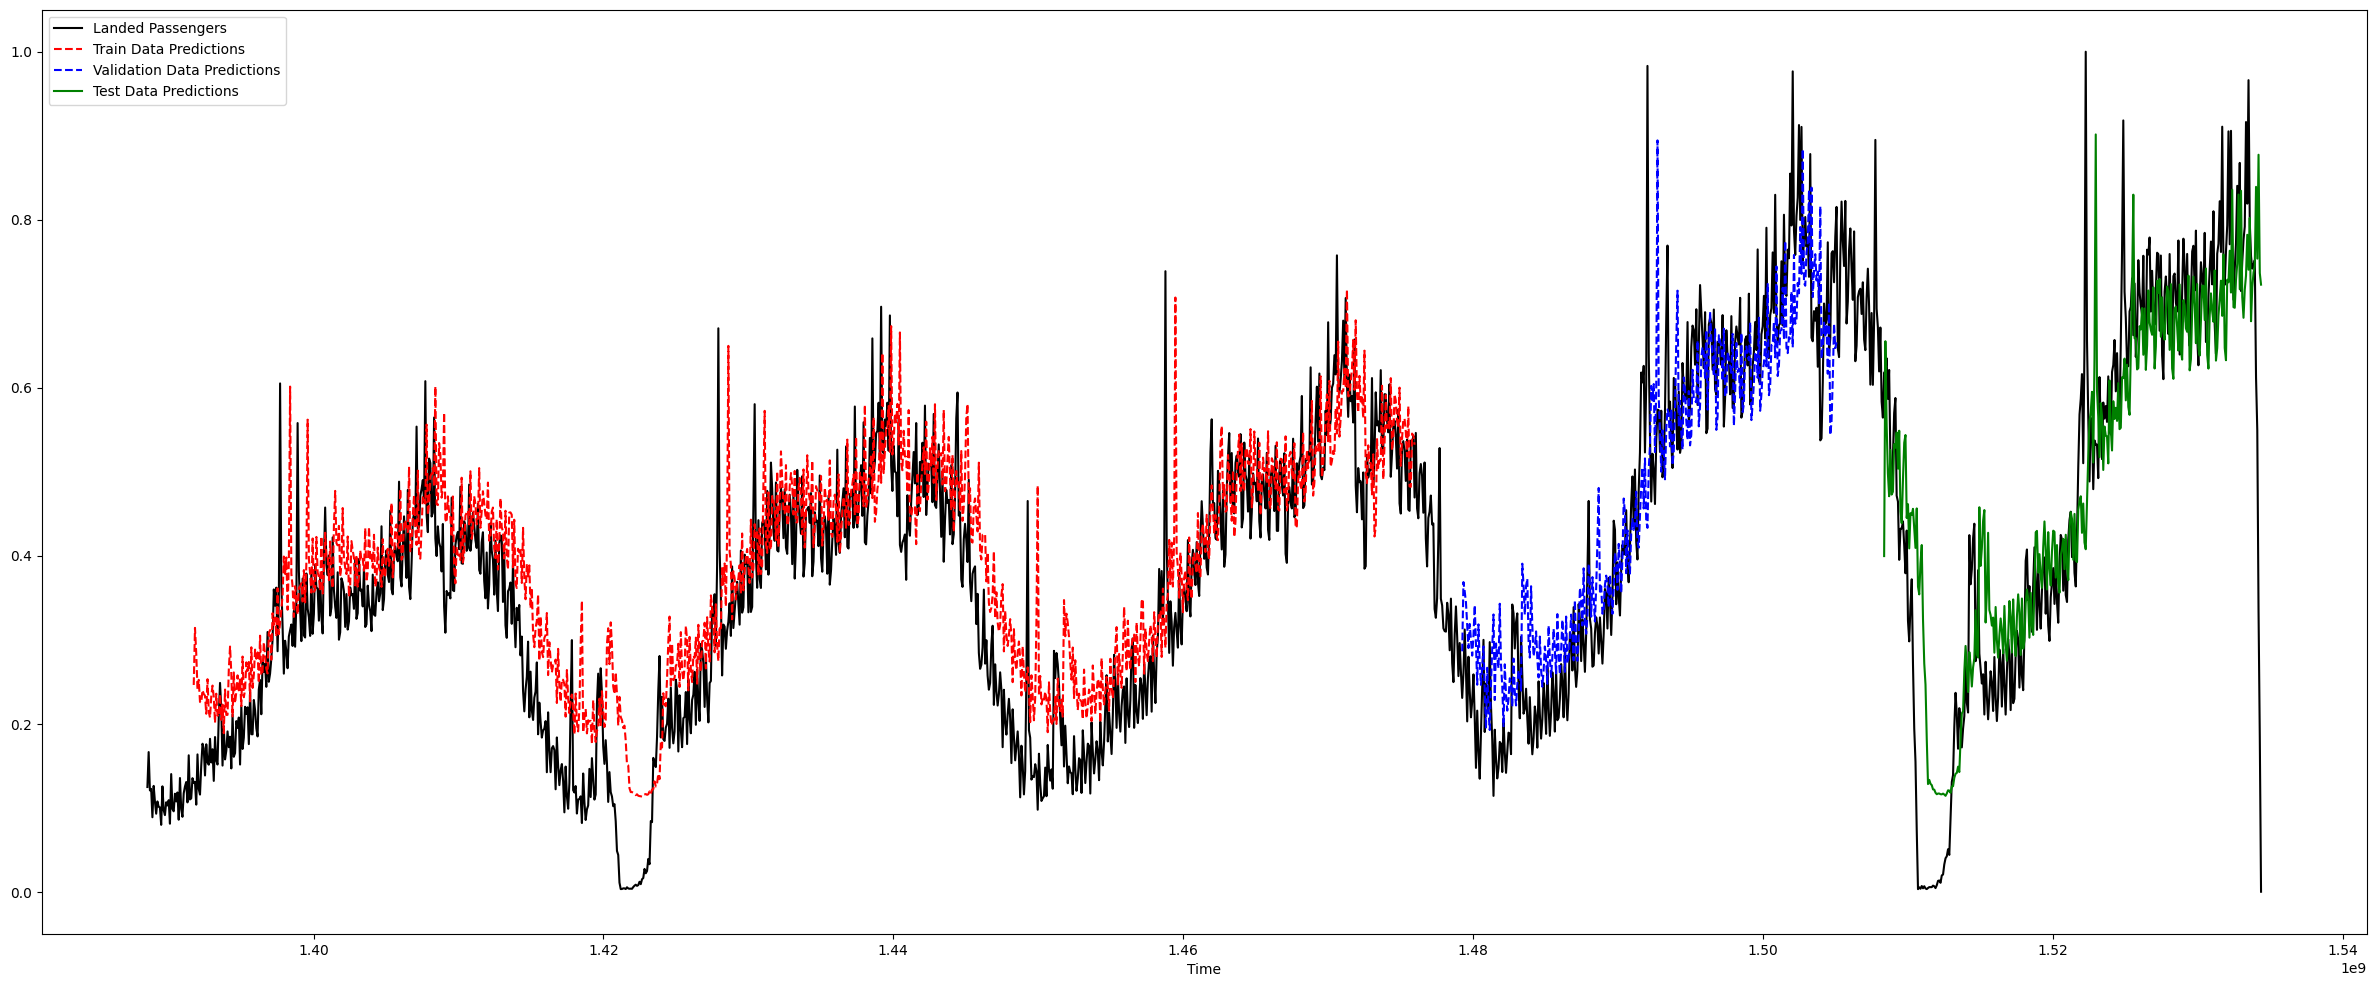

In [450]:
# plot
plt.figure(figsize=(30,12))
plt.plot(date_list,timeseries,c='k',label="Landed Passengers")
plt.plot(date_list,train_plot, c='r', label="Train Data Predictions", linestyle='dashed')
plt.plot(date_list,validation_plot, c='b', label="Validation Data Predictions", linestyle='dashed')
plt.plot(date_list,test_plot, c='g',label="Test Data Predictions")
plt.xlabel("Time")
plt.legend(loc='best')
plt.show()

## Saving Model & Hyperparameters*
*check this out later

In [154]:
"""
filename = PATH + "hyperparameters.txt"

os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, "w") as f:
    f.write(f'''hidden_size = {hidden_size}
num_layers = {num_layers}
learn_rate = {learn_rate}
lookback = {lookback}
''')

torch.save(model.state_dict(), PATH + "model.pkl")


percent_of_train = {percent_of_train}
batch_size = {batch_size}
features = {feature_columns}
best_test_rmse={best_test_rmse}
target = arrivals
epochs = {iterator}
"""

'\nfilename = PATH + "hyperparameters.txt"\n\nos.makedirs(os.path.dirname(filename), exist_ok=True)\nwith open(filename, "w") as f:\n    f.write(f\'\'\'hidden_size = {hidden_size}\nnum_layers = {num_layers}\nlearn_rate = {learn_rate}\nlookback = {lookback}\n\'\'\')\n\ntorch.save(model.state_dict(), PATH + "model.pkl")\n\n\npercent_of_train = {percent_of_train}\nbatch_size = {batch_size}\nfeatures = {feature_columns}\nbest_test_rmse={best_test_rmse}\ntarget = arrivals\nepochs = {iterator}\n'

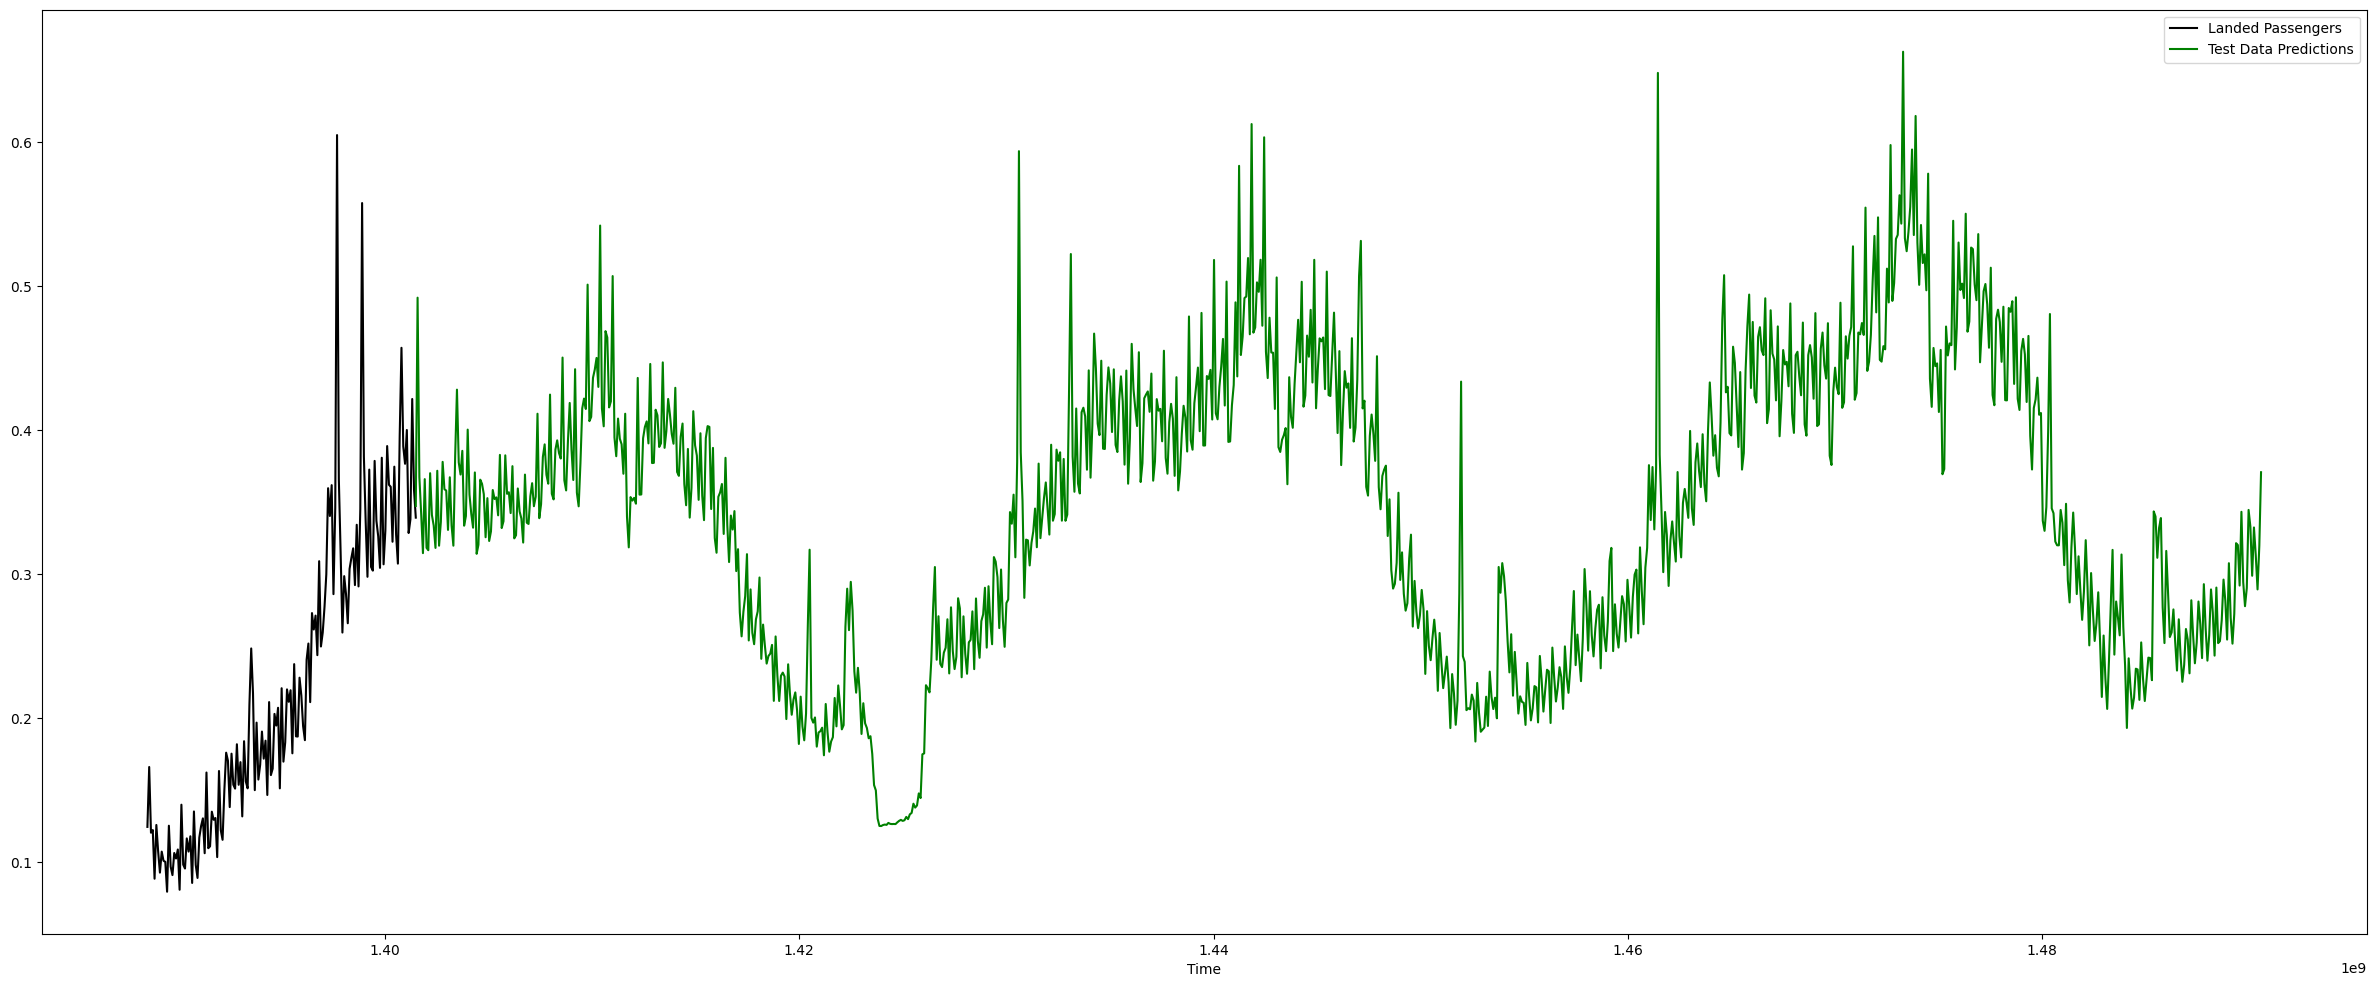

In [183]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    train_plot[lookback+future_step:train_size] = best_model(X_train).cpu()[:, -1, :]

size = int(test_size + val_size + len(y_train))
    
plt.figure(figsize=(30,12))
plt.plot(date_list[:-size],timeseries[:-size],c='k',label="Landed Passengers")
plt.plot(date_list,train_plot, c='g',label="Test Data Predictions")
plt.xlabel("Time")
plt.legend(loc='best')